<div class="alert alert-success">
    <h1 align="center">Cat and Dog : Image Classification </h1>
    <h3 align="center">Seyed Ali Abolfazli </a></h3>
</div>

<h6 align='center'>Kaggle competition: [Dogs vs. Cats](https://www.kaggle.com/c/dogs-vs-cats-redux-kernels-edition)</h6>

<img src='imgs/catsanddogs.png' width='90%'/>

## Objectives

- Image classification
- Four key components of any ML system (in PyTorch):
 - Data (Images)
 - Model (CNN)
 - Loss (Cross Entropy)
 - Optimization (SGD, Adam, ..)
- Convolutional Neural Networks (CNNs)
- Overfit
- Data augmentation
- Transfer learning

## Image Classification

<img src='imgs/Image_tasks.jpg' width='80%'/>

## Libraries

In [2]:
%reload_ext autoreload
%autoreload 2
%matplotlib inline

import math
import time
import os
import glob
import numpy as np
import matplotlib.pyplot as plt
from tqdm import tqdm
from PIL import Image
from sklearn.metrics import confusion_matrix

import torch
import torch.nn as nn
import torch.optim as optim

import torchvision
import torchvision.datasets as datasets
import torchvision.models as models
import torchvision.transforms as transforms

# Our libraries
from train import train_model
from model_utils import *
from predict_utils import *
from vis_utils import *

# some initial setup
np.set_printoptions(precision=2)
use_gpu = torch.cuda.is_available()
np.random.seed(1234)

In [3]:
use_gpu

True

## Data

- train: learning the **parameters** of the model.
- valid: learning **hyper-parameters**.
- test
- development

In [35]:
DATA_DIR = 'D:/ali/cat&dog/dev/'
sz = 224
batch_size = 32

In [40]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [41]:
!apt-get install unrar

Reading package lists... Done
Building dependency tree... Done
Reading state information... Done
unrar is already the newest version (1:6.1.5-1).
0 upgraded, 0 newly installed, 0 to remove and 49 not upgraded.


In [43]:
!unrar x "/content/drive/My Drive/dev.rar" /content/dev/


UNRAR 6.11 beta 1 freeware      Copyright (c) 1993-2022 Alexander Roshal


Extracting from /content/drive/My Drive/dev.rar

Creating    /content/dev                                              OK
Creating    /content/dev/dev                                          OK
Creating    /content/dev/dev/train                                    OK
Creating    /content/dev/dev/train/cat                                OK
Extracting  /content/dev/dev/train/cat/cat.0.jpg                           0%  OK 
Extracting  /content/dev/dev/train/cat/cat.1.jpg                           0%  OK 
Extracting  /content/dev/dev/train/cat/cat.10.jpg                          0%  OK 
Extracting  /content/dev/dev/train/cat/cat.100.jpg                         0%  OK 
Extracting  /content/dev/dev/train/cat/cat.1000.jpg                        0%  OK 
Extracting  /content/dev/dev/train/cat/cat.1001.jpg                        0%  OK 
Extracting  /content/dev/dev/tr

In [48]:


DATA_DIR = '/content/dev/dev/'
if os.path.exists(DATA_DIR):
    print("Files extracted:")
    print(os.listdir(DATA_DIR))
else:
    print("Extraction failed.")


Files extracted:
['valid', 'train']


In [49]:
os.listdir(DATA_DIR)

['valid', 'train']

In [50]:
trn_dir = f'{DATA_DIR}train'
val_dir = f'{DATA_DIR}valid'

In [51]:
os.listdir(trn_dir)

['cat', 'dog']

In [52]:
trn_fnames = glob.glob(f'{trn_dir}/*/*.jpg')
trn_fnames[:5]

['/content/dev/dev/train/cat/cat.1083.jpg',
 '/content/dev/dev/train/cat/cat.644.jpg',
 '/content/dev/dev/train/cat/cat.1842.jpg',
 '/content/dev/dev/train/cat/cat.510.jpg',
 '/content/dev/dev/train/cat/cat.1271.jpg']

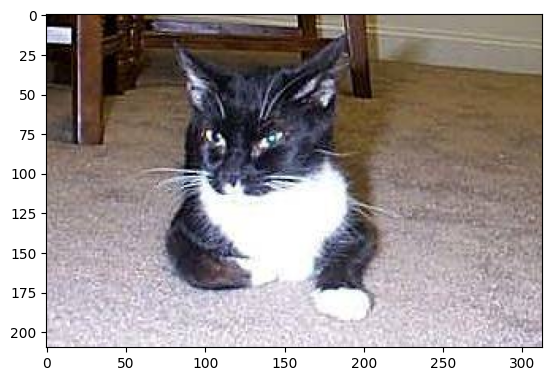

In [53]:
img = plt.imread(trn_fnames[3])
plt.imshow(img);

### Datasets and Dataloaders in PyTorch

- <h6>Dataset</h6>A set of images.
- <h6>Dataloader</h6>Loads data from dataset behind the scene using concurrent threads.

In [54]:
train_ds = datasets.ImageFolder(trn_dir)

In [55]:
train_ds.classes

['cat', 'dog']

In [56]:
train_ds.class_to_idx

{'cat': 0, 'dog': 1}

In [57]:
train_ds.root

'/content/dev/dev/train'

In [58]:
# train_ds.imgs

In [59]:
# list(zip(*train_ds.imgs))

In [60]:
type(train_ds.transform)

NoneType

### Transformations

Dataloader object uses these tranformations when loading data.

In [61]:
tfms = transforms.Compose([
    transforms.Resize((sz, sz)),  # PIL Image
    transforms.ToTensor(),        # Tensor
    transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
])

train_ds = datasets.ImageFolder(trn_dir, transform=tfms)
valid_ds = datasets.ImageFolder(val_dir, transform=tfms)

In [62]:
len(train_ds), len(valid_ds)

(4000, 400)

#### Dataloaders

In [63]:
train_dl = torch.utils.data.DataLoader(train_ds,
                                       batch_size=batch_size,
                                       shuffle=True,
                                       num_workers=8)

valid_dl = torch.utils.data.DataLoader(valid_ds,
                                       batch_size=batch_size,
                                       shuffle=False,
                                       num_workers=8)

/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py:617: UserWarning: This DataLoader will create 8 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(


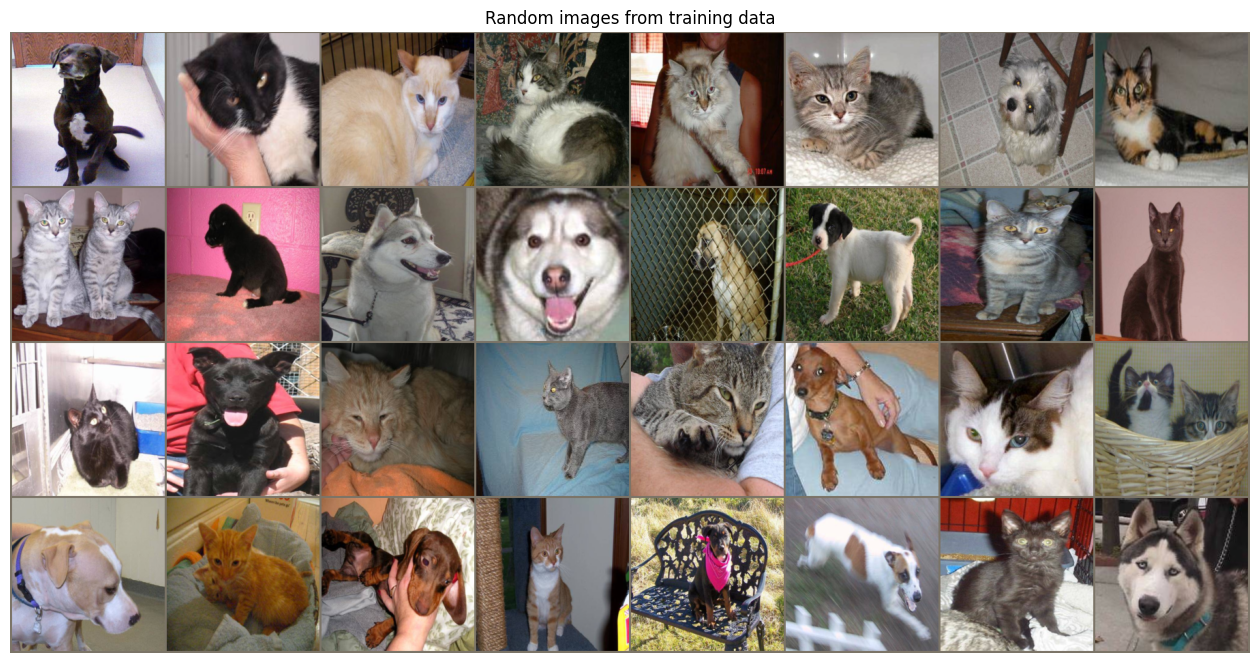

In [64]:
inputs, targets = next(iter(train_dl))
out = torchvision.utils.make_grid(inputs, padding=3)
plt.figure(figsize=(16, 12))
imshow(out, title='Random images from training data')

In [65]:
# ??imshow

## Model: CNN

<img src='imgs/DogAndCats-CNN.jpg' width='100%'/>

In [66]:
class SimpleCNN(nn.Module):

    def __init__(self):
        super(SimpleCNN, self).__init__()

        self.conv1 = nn.Sequential(
            nn.Conv2d(3, 16, kernel_size=5, padding=2),
            nn.BatchNorm2d(16),
            nn.ReLU(),
            nn.MaxPool2d(2)
        )

        self.conv2 = nn.Sequential(
            nn.Conv2d(16, 32, kernel_size=5, padding=2),
            nn.BatchNorm2d(32),
            nn.ReLU(),
            nn.MaxPool2d(2)
        )

        self.fc = nn.Linear(56 * 56 * 32, 2)

    def forward(self, x):
        out = self.conv1(x)
        out = self.conv2(out)            # (bs, C, H,  W)
        out = out.view(out.size(0), -1)  # (bs, C * H, W)
        out = self.fc(out)
        return out

Now, it's time to create the model and to put it on the GPU.

In [67]:
model = SimpleCNN()

# transfer model to GPU, if gpu is available
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

model = model.to(device)

In [68]:
model

SimpleCNN(
  (conv1): Sequential(
    (0): Conv2d(3, 16, kernel_size=(5, 5), stride=(1, 1), padding=(2, 2))
    (1): BatchNorm2d(16, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU()
    (3): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (conv2): Sequential(
    (0): Conv2d(16, 32, kernel_size=(5, 5), stride=(1, 1), padding=(2, 2))
    (1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU()
    (3): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (fc): Linear(in_features=100352, out_features=2, bias=True)
)

## Loss function and optimizer

In [69]:
criterion = nn.CrossEntropyLoss()
optimizer = optim.SGD(model.parameters(), lr=0.002, momentum=0.9)

## Train

In [70]:
num_epochs = 10
losses = []

for epoch in range(num_epochs):
    for i, (inputs, targets) in enumerate(train_dl):
        inputs = inputs.to(device)
        targets = targets.to(device)

        # forwad pass
        outputs = model(inputs)

        # loss
        loss = criterion(outputs, targets)
        losses.append(loss.item())

        # backward pass
        optimizer.zero_grad()
        loss.backward()

        # update parameters
        optimizer.step()

        # report
        if (i + 1) % 50 == 0:
            print('Epoch [%2d/%2d], Step [%3d/%3d], Loss: %.4f'
                  % (epoch + 1, num_epochs, i + 1, len(train_ds) // batch_size, loss.item()))

Epoch [ 1/10], Step [ 50/125], Loss: 1.5639
Epoch [ 1/10], Step [100/125], Loss: 0.8782
Epoch [ 2/10], Step [ 50/125], Loss: 0.6278
Epoch [ 2/10], Step [100/125], Loss: 0.7170
Epoch [ 3/10], Step [ 50/125], Loss: 0.5717
Epoch [ 3/10], Step [100/125], Loss: 0.6624
Epoch [ 4/10], Step [ 50/125], Loss: 0.4862
Epoch [ 4/10], Step [100/125], Loss: 0.6020
Epoch [ 5/10], Step [ 50/125], Loss: 0.5306
Epoch [ 5/10], Step [100/125], Loss: 0.4720
Epoch [ 6/10], Step [ 50/125], Loss: 0.4772
Epoch [ 6/10], Step [100/125], Loss: 0.5693
Epoch [ 7/10], Step [ 50/125], Loss: 0.4523
Epoch [ 7/10], Step [100/125], Loss: 0.4493
Epoch [ 8/10], Step [ 50/125], Loss: 0.3721
Epoch [ 8/10], Step [100/125], Loss: 0.4693
Epoch [ 9/10], Step [ 50/125], Loss: 0.5257
Epoch [ 9/10], Step [100/125], Loss: 0.2951
Epoch [10/10], Step [ 50/125], Loss: 0.1958
Epoch [10/10], Step [100/125], Loss: 0.2771


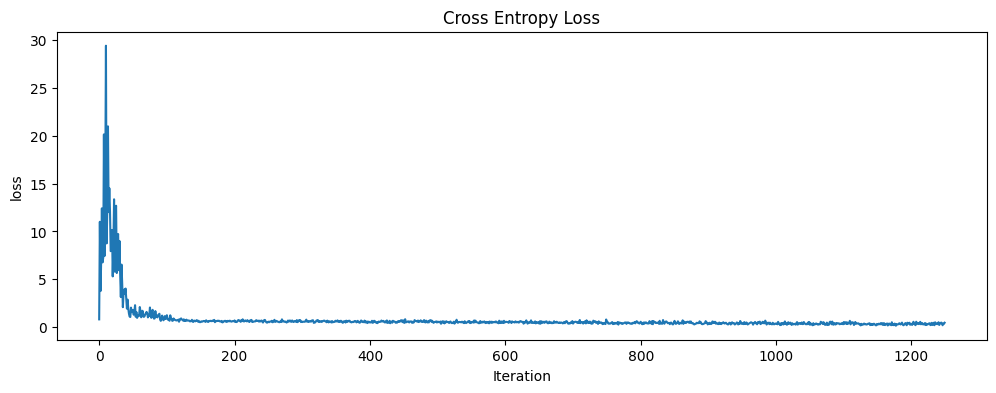

In [71]:
plt.figure(figsize=(12, 4))
plt.plot(losses)
plt.xlabel('Iteration')
plt.ylabel('loss')
plt.title('Cross Entropy Loss')
plt.show()

### Analyze results

#### Accuracy on validation data

In [72]:
def evaluate_model(model, dataloader, device):
    model.eval()  # for batch normalization layers
    corrects = 0

    with torch.no_grad():
        for inputs, targets in dataloader:
            inputs, targets = inputs.to(device), targets.to(device)
            outputs = model(inputs)
            _, preds = torch.max(outputs, 1)
            corrects += (preds == targets.data).sum()

    print('accuracy: {:.2f}'.format(100. * corrects / len(dataloader.dataset)))

In [73]:
evaluate_model(model, valid_dl, device)

accuracy: 67.25


In [74]:
evaluate_model(model, train_dl, device)

accuracy: 89.98


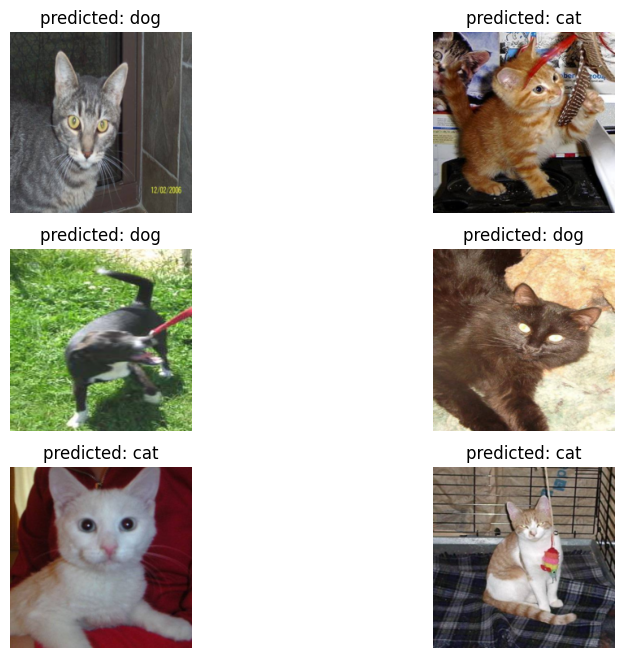

In [75]:
visualize_model(model, train_dl, device)

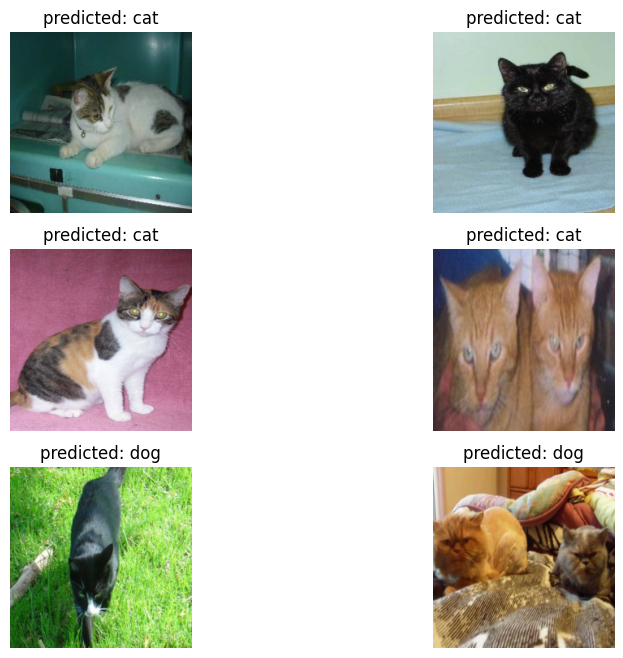

In [76]:
visualize_model(model, valid_dl, device)

100%|██████████| 13/13 [00:02<00:00,  4.76it/s]


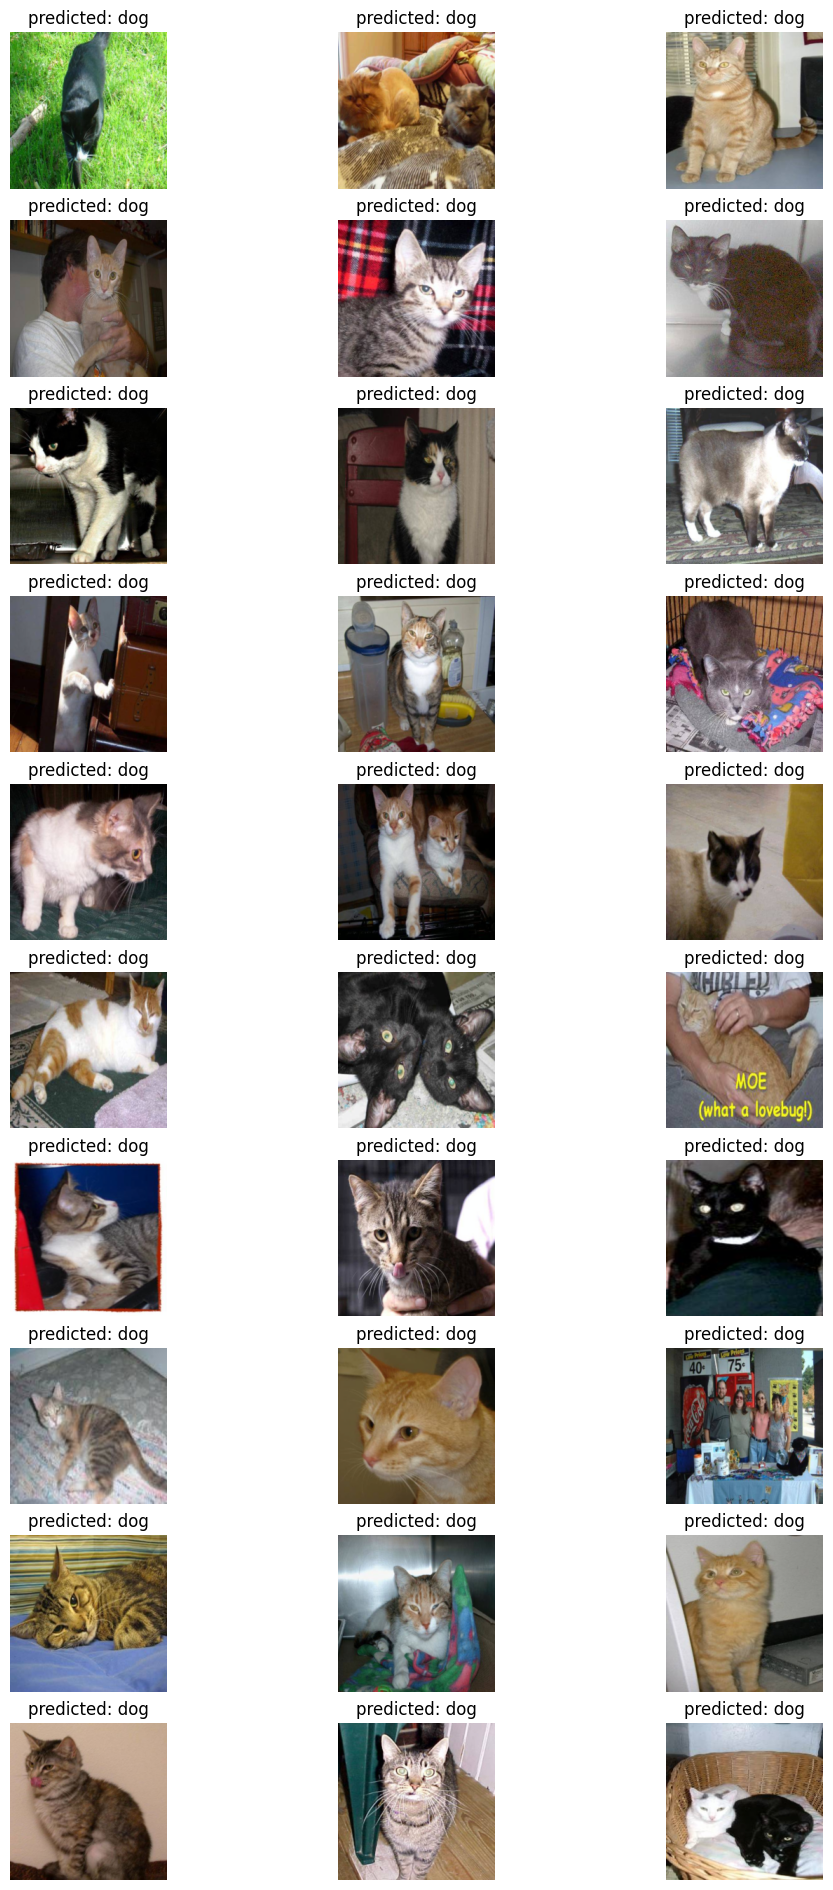

41 images out of 400 were misclassified.


In [77]:
plot_errors(model, valid_dl, device)

#### Confusion matrix

100%|██████████| 13/13 [00:02<00:00,  4.80it/s]


[[0.67 0.34]
 [0.32 0.68]]


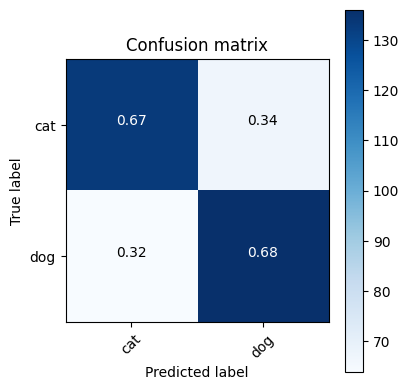

In [78]:
y_pred, y_true = predict_class(model, valid_dl, device)
cm = confusion_matrix(y_true, y_pred)
plot_confusion_matrix(cm, train_ds.classes, normalize=True, figsize=(4, 4))

## Overfit

<div class="alert alert-success">
    <strong>What is OVERFIT? </strong>
    <ul>
        <li>The most important concept in ML!</li>
        <li>Simply, it means that your model is too complex for your problem.</li>
    </ul>
</div>

<h6>What we can do about it?</h6>

- Regularization
- Dropout
- Data Augmentation
- Transfer Learning

## Data Augmentation

<img src='imgs/Augmentation.jpg' width='90%'/>

<h6>Possible Transformations:</h6>
- Scaling
- Rotation
- Translation
- Flip horizontaly
- Random Crop
- Color jitter
- many more!

<img src='imgs/Augmentation-Examples.jpg' width='75%'/>

In [79]:
# Data augmentation and normalization for training
train_transforms = transforms.Compose([
    transforms.Resize((sz, sz)),
    transforms.RandomHorizontalFlip(),
    transforms.ColorJitter(0.1, 0.1, 0.1, 0.01),
    transforms.RandomRotation(20),
    transforms.ToTensor(),
    transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
])

# Just normalization for validation
valid_transforms = transforms.Compose([
    transforms.Resize((sz, sz)),
    transforms.ToTensor(),
    transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
])

train_ds = datasets.ImageFolder(f'{DATA_DIR}train', train_transforms)
valid_ds = datasets.ImageFolder(f'{DATA_DIR}valid', valid_transforms)

train_dl = torch.utils.data.DataLoader(train_ds, batch_size=batch_size, shuffle=True)
valid_dl = torch.utils.data.DataLoader(valid_ds, batch_size=batch_size, shuffle=True)

train_ds_sz = len(train_ds)
valid_ds_sz = len(valid_ds)

print('Train size: {}\nValid size: {} ({:.2f})'.format(train_ds_sz, valid_ds_sz, valid_ds_sz/(train_ds_sz + valid_ds_sz)))

class_names = train_ds.classes

Train size: 4000
Valid size: 400 (0.09)


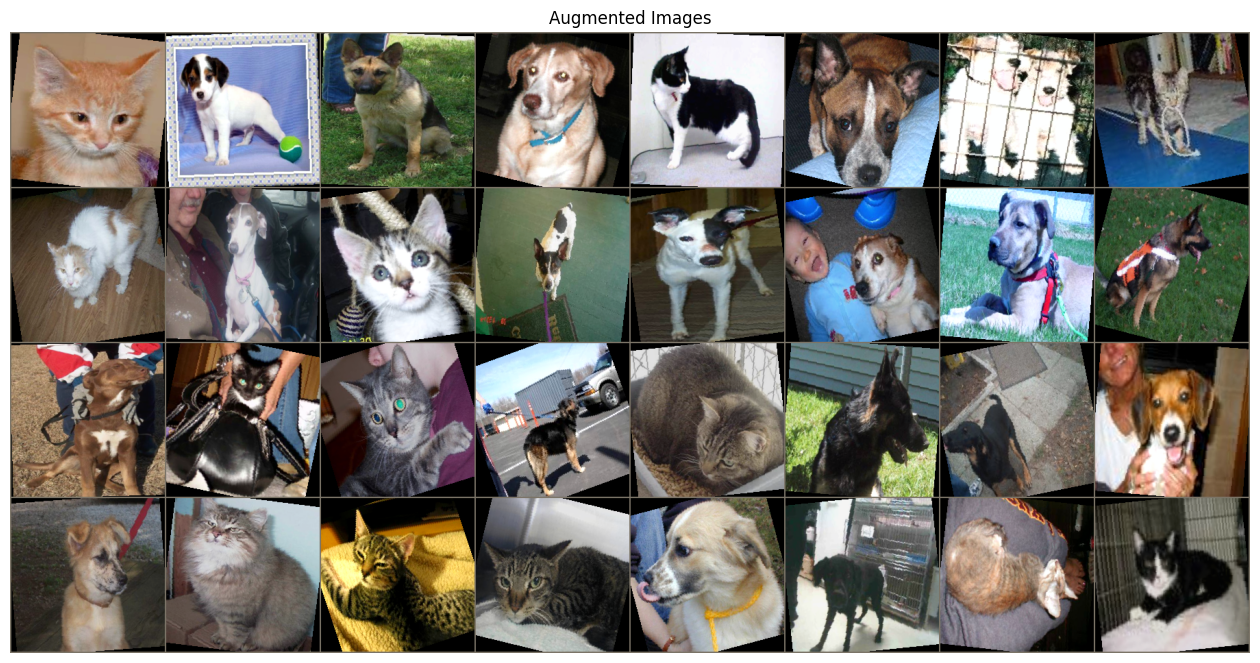

In [80]:
inputs, targets = next(iter(train_dl))     # Get a batch of training data
out = torchvision.utils.make_grid(inputs)  # Make a grid from batch
plt.figure(figsize=(16., 12.))
imshow(out, title='Augmented Images');

#### Look at the sizes of the images

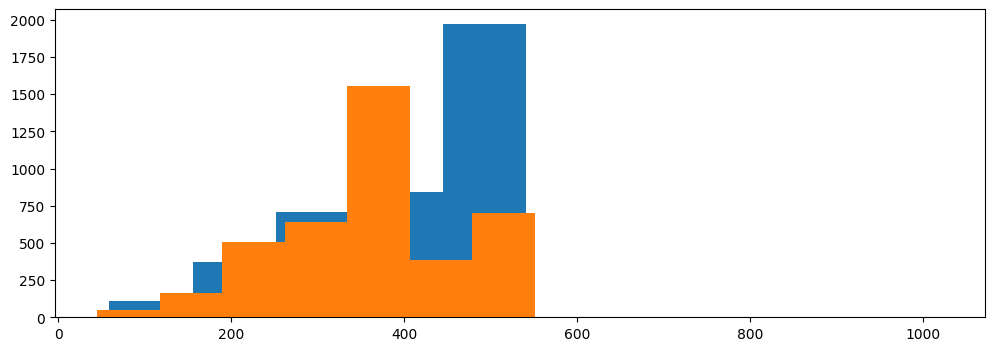

In [81]:
fnames = glob.glob(f'{trn_dir}/*/*.jpg')
sizes = [Image.open(f).size for f in fnames]

hs, ws = list(zip(*sizes))

plt.figure(figsize=(12., 4.))
plt.hist(hs)
plt.hist(ws);

In [82]:
# create model
model = SimpleCNN()
model = model.to(device)

# loss and optimizer
criterion = nn.CrossEntropyLoss()
optimizer = optim.SGD(model.parameters(), lr=0.002, momentum=0.9)

# train
model = train_model(model, train_dl, valid_dl, criterion, optimizer, device, num_epochs=5)

Epoch 1/5
----------
  train Loss: 3.78578 Acc: 0.53675
  valid Loss: 0.66008 Acc: 0.63000

Epoch 2/5
----------
  train Loss: 0.66032 Acc: 0.60900
  valid Loss: 0.64434 Acc: 0.62250

Epoch 3/5
----------
  train Loss: 0.62989 Acc: 0.64325
  valid Loss: 0.62661 Acc: 0.64750

Epoch 4/5
----------
  train Loss: 0.62542 Acc: 0.64500
  valid Loss: 0.60698 Acc: 0.68250

Epoch 5/5
----------
  train Loss: 0.60426 Acc: 0.66900
  valid Loss: 0.60297 Acc: 0.67250

Training complete in 4m 4s
Best val Acc: 0.6825


## Transfer Learning

- Use a CNN already trained on different data (e.g., [ImageNet](http://www.image-net.org/))
- Just Train the classifier weights (Last Layer)

<img src='imgs/transfer-learning.jpg' width='80%'/>

In [83]:
# load pre-trained ResNet18
model = load_pretrained_resnet50(model_path=None, num_classes=2)
model = model.to(device)

# loss and optimizer
criterion = nn.CrossEntropyLoss()
optimizer = optim.SGD(model.parameters(), lr=0.002, momentum=0.9)
scheduler = optim.lr_scheduler.StepLR(optimizer, step_size=2, gamma=0.9)

/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet50_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet50_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
Downloading: "https://download.pytorch.org/models/resnet50-0676ba61.pth" to /root/.cache/torch/hub/checkpoints/resnet50-0676ba61.pth
100%|██████████| 97.8M/97.8M [00:00<00:00, 191MB/s]


In [84]:
model = train_model(model, train_dl, valid_dl, criterion, optimizer, device, scheduler, num_epochs=2)

Epoch 1/2
----------
  train Loss: 0.11223 Acc: 0.95925
  valid Loss: 0.04901 Acc: 0.98500

Epoch 2/2
----------
  train Loss: 0.04001 Acc: 0.98850
  valid Loss: 0.05753 Acc: 0.98500

Training complete in 2m 40s
Best val Acc: 0.9850


In [85]:
evaluate_model(model, valid_dl, device)

accuracy: 98.50


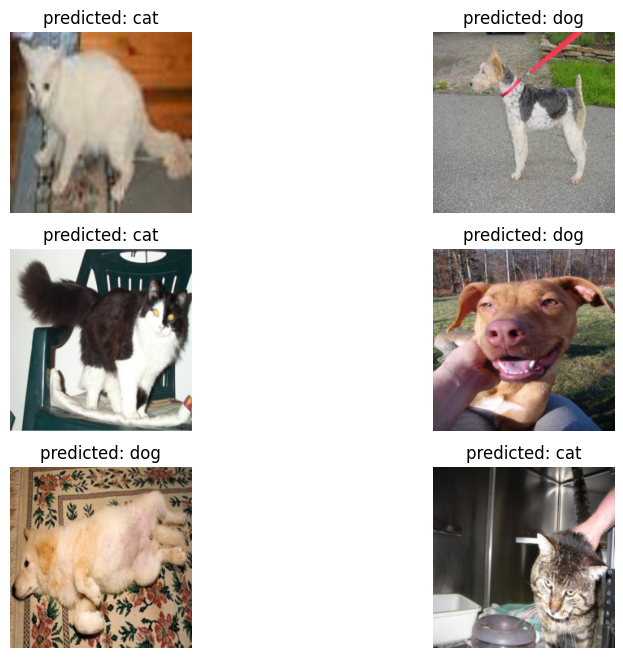

In [86]:
visualize_model(model, valid_dl, device, num_images=6)

100%|██████████| 13/13 [00:02<00:00,  4.93it/s]


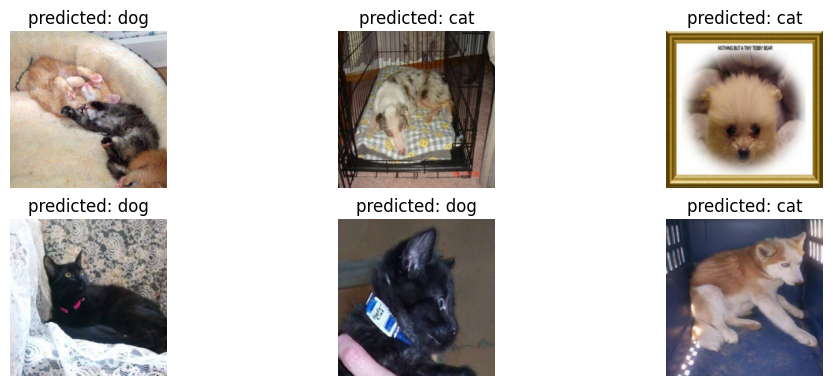

6 images out of 400 were misclassified.


In [87]:
plot_errors(model, valid_dl, device)